# ResNet Ablation Study

### 0) 라이브러리 버전 확인하기
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

print(tf.__version__)
print(np.__version__)

/Users/louan/.pyenv/versions/3.9.13/envs/img/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.11.0
1.24.1


### <참고>
- [resnet 34](https://www.kaggle.com/code/mishki/resnet-keras-code-from-scratch-train-on-gpu)

- [understanding input output shapes in CNN(convolution neural network)](https://towardsdatascience.com/understanding-input-and-output-shapes-in-convolution-network-keras-f143923d56ca)

- [Conv2d layer를 겹겹이 쌓을 때 최종 output volume 계산법](https://teddylee777.github.io/pytorch/conv2d-output-size-%EA%B3%84%EC%82%B0%EB%B2%95/)

- [깔끔한 클래스 형식 ResNet 구현](https://github.com/safwankdb/ResNet34-TF2/blob/master/model.py)

### 1) ResNet 기본 블록 구성하기
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

- [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)
- [빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

Q. ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.
<details>
    <summary>정답 확인</summary>
    ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.
</details>

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. Learning by Doing 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.

우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇 번의 경험이 있습니다.
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.

그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.

하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현 방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.



In [6]:
# image processing
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [7]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-22 17:56:26.922288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-22 17:56:26.922582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
BATCH_SIZE = 256
EPOCH = 15

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

## 2) ResNet-34, ResNet-50 Complete Model
---
><br>
>ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.<br>
><br>

##### ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

In [6]:
# 블록 1개를 만드는 메소드 ResNet-34

def build_resnet34_block(input_layer, block_num, channel=64, stage_num=1, is_plain = False):
    # 입력 레이어
    x = input_layer
    x_shortcut = x # 뒤에 합쳐줄 shorcut_layer
    
    layer = 1
    conv_name = f'stage{stage_num}_{block_num}' + '_{type}_{layer}'
    # Convolution 레이어 - 1
    if int(stage_num) >=3 and int(block_num) == 1:
        print(stage_num)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same', strides = 2, name=conv_name.format(type='conv', layer = layer))(x)    
    else:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same', name=conv_name.format(type='conv', layer = layer))(x)    
    x = keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    layer += 1
    
    # Convolution 레이어 - 2
    x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same', name=conv_name.format(type='conv', layer = layer))(x)    
    x = keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    layer += 1

    if is_plain == False:
        # add shortcut branch to main path
        if int(stage_num) >=3 and int(block_num) == 1:
            x_shortcut = keras.layers.Conv2D(filters = channel, strides = 2, kernel_size = (1,1))(x_shortcut)   
            x_shortcut = keras.layers.BatchNormalization()(x_shortcut)
        else:
            pass
        x = Add()([x, x_shortcut])
    else:
        pass

    # relu activation at the end of the block
    x = Activation('relu')(x)

    return x

In [7]:
# 블록 1개를 만드는 메소드 ResNet-50

def build_resnet50_block(input_layer, block_num, channel=64, stage_num=1, is_plain = False):
    # 입력 레이어
    x = input_layer
    x_shortcut = x # 뒤에 합쳐줄 shorcut_layer
    
    layer = 1
    conv_name = f'stage{stage_num}_{block_num}' + '_{type}_{layer}'
    # Convolution 레이어 - 1
    if int(stage_num) >=3 and int(block_num) == 1:
        print(stage_num)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), kernel_initializer='he_normal', padding='same', strides = 2, name=conv_name.format(type='conv', layer = layer))(x)    
    else:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), kernel_initializer='he_normal', padding='same', name=conv_name.format(type='conv', layer = layer))(x)    
    x = keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    layer += 1
    
    # Convolution 레이어 - 2
    x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), kernel_initializer='he_normal', padding='same', name=conv_name.format(type='conv', layer = layer))(x)    
    x = keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    layer += 1

    # Convolution 레이어 - 3
    x = keras.layers.Conv2D(filters=channel*4, kernel_size=(1,1), kernel_initializer='he_normal', padding='same', name=conv_name.format(type='conv', layer = layer))(x)    
    x = keras.layers.BatchNormalization()(x)
    # x = Activation('relu')(x)
    layer += 1

    
    # merge shortcut branch to main path
    if int(stage_num) >=3 and int(block_num) == 1:
        x_shortcut = keras.layers.Conv2D(filters = channel*4, strides = 2, kernel_size = (1,1), name = "short_" + conv_name.format(type='conv', layer = layer))(x_shortcut)   
        x_shortcut = keras.layers.BatchNormalization()(x_shortcut)
    elif int(stage_num) ==2 and int(block_num) == 1:
        x_shortcut = keras.layers.Conv2D(filters = channel*4, kernel_size = (1,1), name = "short_" + conv_name.format(type='conv', layer = layer))(x_shortcut)   
        x_shortcut = keras.layers.BatchNormalization()(x_shortcut)
    else:
        pass
    
    x = Add()([x, x_shortcut])

    # relu activation at the end of the block
    x = Activation('relu')(x)

    return x

In [8]:
def build_resnet(num_classes, input_shape = (32,32,3), is_50=False, is_plain = False):
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = keras.layers.Conv2D(filters=64, kernel_size = (7,7), strides = 2, padding = 'same')(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = Activation('relu')(output)
    output = keras.layers.MaxPool2D(pool_size=(3, 3), strides= 2, padding = 'same')(output)
    
    if is_50: # ResNet 50
        print("build 50 mode!") # to be deleted
        cnn_blocks_list=[3,4,6,3]
        channel_list=[64,128,256,512]
        
        for stage_num, (blocks, channel) in enumerate(zip(cnn_blocks_list, channel_list)):                    
            block_num = 1
            for block in range(blocks):
                output = build_resnet50_block(output, block_num, channel=channel, stage_num=str(stage_num+2), is_plain = False)
                block_num += 1
    else: # ResNet 34
        print("build 34 mode!") # to be deleted
        cnn_blocks_list=[3,4,6,3]
        channel_list=[64,128,256,512]
        
        for stage_num, (blocks, channel) in enumerate(zip(cnn_blocks_list, channel_list)):                    
            block_num = 1
            for block in range(blocks):
                output = build_resnet34_block(output, block_num, channel=channel, stage_num=str(stage_num+2), is_plain = False)
                block_num += 1
                         
    output = keras.layers.AveragePooling2D(pool_size=(1,1))(output)
    output = Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    if is_50: # ResNet 50
        model = keras.Model(inputs=input_layer, outputs=output, name = 'resnet_50')
    else:
        model = keras.Model(inputs=input_layer, outputs=output, name = 'resnet_34')

    return model

In [57]:
resnet_34_model = build_resnet(num_classes = 10, is_50=False)
resnet_34_model.summary()

build 34 mode!
3
4
5
Model: "resnet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_55 (Conv2D)             (None, 16, 16, 64)   9472        ['input_31[0][0]']               
                                                                                                  
 batch_normalization_355 (Batch  (None, 16, 16, 64)  256         ['conv2d_55[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_325 (Activation)    (None, 16, 16, 64)   0           ['ba

In [ ]:
plot_model(resnet_34_model, to_file='model_shapes.png', show_shapes=True)

In [59]:
resnet_34_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

In [60]:
history_34 = resnet_34_model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


2023-02-23 14:22:34.975661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - ETA: 0s - loss: 2.9848 - accuracy: 0.1592

2023-02-23 14:26:05.733475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - 233s 1s/step - loss: 2.9848 - accuracy: 0.1592 - val_loss: 2.4823 - val_accuracy: 0.0967
Epoch 2/15
195/195 [==============================] - 211s 1s/step - loss: 2.3070 - accuracy: 0.2458 - val_loss: 2.7170 - val_accuracy: 0.1351
Epoch 3/15
195/195 [==============================] - 207s 1s/step - loss: 2.0634 - accuracy: 0.3019 - val_loss: 2.2137 - val_accuracy: 0.2387
Epoch 4/15
195/195 [==============================] - 187s 959ms/step - loss: 1.9015 - accuracy: 0.3446 - val_loss: 2.0786 - val_accuracy: 0.2860
Epoch 5/15
195/195 [==============================] - 193s 983ms/step - loss: 1.7703 - accuracy: 0.3855 - val_loss: 2.0621 - val_accuracy: 0.3108
Epoch 6/15
195/195 [==============================] - 219s 1s/step - loss: 1.6661 - accuracy: 0.4227 - val_loss: 2.0244 - val_accuracy: 0.3224
Epoch 7/15
195/195 [==============================] - 212s 1s/step - loss: 1.5597 - accuracy: 0.4558 - val_loss: 1.9623 - val_accuracy: 0.3396
Epoc

다음의 결과가 나와야 합니다. 
<details>
    <summary>결과</summary>
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_layer (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_layer[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 16, 16, 64)   0           conv1_bn[0][0]                       
__________________________________________________________________________________________________
pool1_pool (MaxPooling2D)       (None, 8, 8, 64)     0           conv1_relu[0][0]                  
__________________________________________________________________________________________________
conv2_block1_1_conv (Conv2D)    (None, 8, 8, 64)     4160        pool1_pool[0][0]                 
__________________________________________________________________________________________________
conv2_block1_1_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_1_relu (Activation (None, 8, 8, 64)     0           conv2_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_2_conv (Conv2D)    (None, 8, 8, 64)     36928       conv2_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block1_2_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_2_relu (Activation (None, 8, 8, 64)     0           conv2_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_0_conv (Conv2D)    (None, 8, 8, 256)    16640       pool1_pool[0][0]                 
__________________________________________________________________________________________________
conv2_block1_3_conv (Conv2D)    (None, 8, 8, 256)    16640       conv2_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 8, 8, 256)    1024        conv2_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_3_bn (BatchNormali (None, 8, 8, 256)    1024        conv2_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_add (Add)          (None, 8, 8, 256)    0           conv2_block1_0_bn[0][0]          
                                                                 conv2_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_out (Activation)   (None, 8, 8, 256)    0           conv2_block1_add[0][0]           
__________________________________________________________________________________________________
conv2_block2_1_conv (Conv2D)    (None, 8, 8, 64)     16448       conv2_block1_out[0][0]           
__________________________________________________________________________________________________
conv2_block2_1_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_1_relu (Activation (None, 8, 8, 64)     0           conv2_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_2_conv (Conv2D)    (None, 8, 8, 64)     36928       conv2_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block2_2_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_2_relu (Activation (None, 8, 8, 64)     0           conv2_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_3_conv (Conv2D)    (None, 8, 8, 256)    16640       conv2_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block2_3_bn (BatchNormali (None, 8, 8, 256)    1024        conv2_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_add (Add)          (None, 8, 8, 256)    0           conv2_block1_out[0][0]           
                                                                 conv2_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_out (Activation)   (None, 8, 8, 256)    0           conv2_block2_add[0][0]           
__________________________________________________________________________________________________
conv2_block3_1_conv (Conv2D)    (None, 8, 8, 64)     16448       conv2_block2_out[0][0]           
__________________________________________________________________________________________________
conv2_block3_1_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_relu (Activation (None, 8, 8, 64)     0           conv2_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_2_conv (Conv2D)    (None, 8, 8, 64)     36928       conv2_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_2_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_2_relu (Activation (None, 8, 8, 64)     0           conv2_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_3_conv (Conv2D)    (None, 8, 8, 256)    16640       conv2_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_3_bn (BatchNormali (None, 8, 8, 256)    1024        conv2_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_add (Add)          (None, 8, 8, 256)    0           conv2_block2_out[0][0]           
                                                                 conv2_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_out (Activation)   (None, 8, 8, 256)    0           conv2_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, 4, 4, 128)    32896       conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, 4, 4, 128)    0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, 4, 4, 128)    147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block1_2_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_2_relu (Activation (None, 4, 4, 128)    0           conv3_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_0_conv (Conv2D)    (None, 4, 4, 512)    131584      conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_3_conv (Conv2D)    (None, 4, 4, 512)    66048       conv3_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block1_0_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_3_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_add (Add)          (None, 4, 4, 512)    0           conv3_block1_0_bn[0][0]          
                                                                 conv3_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_out (Activation)   (None, 4, 4, 512)    0           conv3_block1_add[0][0]           
__________________________________________________________________________________________________
conv3_block2_1_conv (Conv2D)    (None, 4, 4, 128)    65664       conv3_block1_out[0][0]           
__________________________________________________________________________________________________
conv3_block2_1_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_1_relu (Activation (None, 4, 4, 128)    0           conv3_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_2_conv (Conv2D)    (None, 4, 4, 128)    147584      conv3_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block2_2_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_2_relu (Activation (None, 4, 4, 128)    0           conv3_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_3_conv (Conv2D)    (None, 4, 4, 512)    66048       conv3_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block2_3_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_add (Add)          (None, 4, 4, 512)    0           conv3_block1_out[0][0]           
                                                                 conv3_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_out (Activation)   (None, 4, 4, 512)    0           conv3_block2_add[0][0]           
__________________________________________________________________________________________________
conv3_block3_1_conv (Conv2D)    (None, 4, 4, 128)    65664       conv3_block2_out[0][0]           
__________________________________________________________________________________________________
conv3_block3_1_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_1_relu (Activation (None, 4, 4, 128)    0           conv3_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_2_conv (Conv2D)    (None, 4, 4, 128)    147584      conv3_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block3_2_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_2_relu (Activation (None, 4, 4, 128)    0           conv3_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_3_conv (Conv2D)    (None, 4, 4, 512)    66048       conv3_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block3_3_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_add (Add)          (None, 4, 4, 512)    0           conv3_block2_out[0][0]           
                                                                 conv3_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_out (Activation)   (None, 4, 4, 512)    0           conv3_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block4_1_conv (Conv2D)    (None, 4, 4, 128)    65664       conv3_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block4_1_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, 4, 4, 128)    0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, 4, 4, 128)    147584      conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, 4, 4, 128)    0           conv3_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_3_conv (Conv2D)    (None, 4, 4, 512)    66048       conv3_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 4, 4, 512)    0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 4, 4, 512)    0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 2, 2, 256)    131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 2, 2, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 2, 2, 256)    0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 2, 2, 1024)   525312      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_0_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_add (Add)          (None, 2, 2, 1024)   0           conv4_block1_0_bn[0][0]          
                                                                 conv4_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_out (Activation)   (None, 2, 2, 1024)   0           conv4_block1_add[0][0]           
__________________________________________________________________________________________________
conv4_block2_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block1_out[0][0]           
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 2, 2, 256)    0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_relu (Activation (None, 2, 2, 256)    0           conv4_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_add (Add)          (None, 2, 2, 1024)   0           conv4_block1_out[0][0]           
                                                                 conv4_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_out (Activation)   (None, 2, 2, 1024)   0           conv4_block2_add[0][0]           
__________________________________________________________________________________________________
conv4_block3_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block2_out[0][0]           
__________________________________________________________________________________________________
conv4_block3_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_1_relu (Activation (None, 2, 2, 256)    0           conv4_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_2_relu (Activation (None, 2, 2, 256)    0           conv4_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_add (Add)          (None, 2, 2, 1024)   0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_out (Activation)   (None, 2, 2, 1024)   0           conv4_block3_add[0][0]           
__________________________________________________________________________________________________
conv4_block4_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_1_relu (Activation (None, 2, 2, 256)    0           conv4_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, 2, 2, 256)    0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 2, 2, 1024)   0           conv4_block3_out[0][0]           
                                                                 conv4_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_out (Activation)   (None, 2, 2, 1024)   0           conv4_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 2, 2, 256)    0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_relu (Activation (None, 2, 2, 256)    0           conv4_block5_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block5_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block5_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_add (Add)          (None, 2, 2, 1024)   0           conv4_block4_out[0][0]           
                                                                 conv4_block5_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_out (Activation)   (None, 2, 2, 1024)   0           conv4_block5_add[0][0]           
__________________________________________________________________________________________________
conv4_block6_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block5_out[0][0]           
__________________________________________________________________________________________________
conv4_block6_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block6_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_1_relu (Activation (None, 2, 2, 256)    0           conv4_block6_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block6_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block6_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block6_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_2_relu (Activation (None, 2, 2, 256)    0           conv4_block6_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block6_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block6_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block6_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_add (Add)          (None, 2, 2, 1024)   0           conv4_block5_out[0][0]           
                                                                 conv4_block6_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_out (Activation)   (None, 2, 2, 1024)   0           conv4_block6_add[0][0]           
__________________________________________________________________________________________________
conv5_block1_1_conv (Conv2D)    (None, 1, 1, 512)    524800      conv4_block6_out[0][0]           
__________________________________________________________________________________________________
conv5_block1_1_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_1_relu (Activation (None, 1, 1, 512)    0           conv5_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_2_conv (Conv2D)    (None, 1, 1, 512)    2359808     conv5_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_relu (Activation (None, 1, 1, 512)    0           conv5_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_0_conv (Conv2D)    (None, 1, 1, 2048)   2099200     conv4_block6_out[0][0]           
__________________________________________________________________________________________________
conv5_block1_3_conv (Conv2D)    (None, 1, 1, 2048)   1050624     conv5_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block1_0_bn (BatchNormali (None, 1, 1, 2048)   8192        conv5_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_3_bn (BatchNormali (None, 1, 1, 2048)   8192        conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_add (Add)          (None, 1, 1, 2048)   0           conv5_block1_0_bn[0][0]          
                                                                 conv5_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_out (Activation)   (None, 1, 1, 2048)   0           conv5_block1_add[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, 1, 1, 512)    1049088     conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 1, 1, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 1, 1, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 1, 1, 512)    0           conv5_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_3_conv (Conv2D)    (None, 1, 1, 2048)   1050624     conv5_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_3_bn (BatchNormali (None, 1, 1, 2048)   8192        conv5_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_add (Add)          (None, 1, 1, 2048)   0           conv5_block1_out[0][0]           
                                                                 conv5_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_out (Activation)   (None, 1, 1, 2048)   0           conv5_block2_add[0][0]           
__________________________________________________________________________________________________
conv5_block3_1_conv (Conv2D)    (None, 1, 1, 512)    1049088     conv5_block2_out[0][0]           
__________________________________________________________________________________________________
conv5_block3_1_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_1_relu (Activation (None, 1, 1, 512)    0           conv5_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_2_conv (Conv2D)    (None, 1, 1, 512)    2359808     conv5_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_2_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_2_relu (Activation (None, 1, 1, 512)    0           conv5_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_3_conv (Conv2D)    (None, 1, 1, 2048)   1050624     conv5_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_3_bn (BatchNormali (None, 1, 1, 2048)   8192        conv5_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_add (Add)          (None, 1, 1, 2048)   0           conv5_block2_out[0][0]           
                                                                 conv5_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_out (Activation)   (None, 1, 1, 2048)   0           conv5_block3_add[0][0]           
==================================================================================================
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________
</details>

In [43]:
resnet_50_model = build_resnet(num_classes = 10, is_50=True)
resnet_50_model.summary()

build 50 mode!
3
4
5
Model: "resnet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_50 (Conv2D)             (None, 16, 16, 64)   9472        ['input_27[0][0]']               
                                                                                                  
 batch_normalization_266 (Batch  (None, 16, 16, 64)  256         ['conv2d_50[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_227 (Activation)    (None, 16, 16, 64)   0           ['ba

In [ ]:
plot_model(resnet_50_model, to_file='model_shapes.png', show_shapes=True)

In [45]:
resnet_50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

In [47]:
history_50 = resnet_50_model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - ETA: 0s - loss: 3.1983 - accuracy: 0.1116

2023-02-23 11:04:46.469683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - 161s 817ms/step - loss: 3.1983 - accuracy: 0.1116 - val_loss: 2.4868 - val_accuracy: 0.1068
Epoch 2/15
195/195 [==============================] - 159s 814ms/step - loss: 2.9750 - accuracy: 0.1233 - val_loss: 2.6530 - val_accuracy: 0.1100
Epoch 3/15
195/195 [==============================] - 261s 1s/step - loss: 2.8459 - accuracy: 0.1364 - val_loss: 2.7031 - val_accuracy: 0.1285
Epoch 4/15
195/195 [==============================] - 281s 1s/step - loss: 2.7850 - accuracy: 0.1408 - val_loss: 2.7618 - val_accuracy: 0.1239
Epoch 5/15
195/195 [==============================] - 236s 1s/step - loss: 2.7168 - accuracy: 0.1487 - val_loss: 2.7967 - val_accuracy: 0.1386
Epoch 6/15
195/195 [==============================] - 240s 1s/step - loss: 2.6470 - accuracy: 0.1590 - val_loss: 2.7699 - val_accuracy: 0.1454
Epoch 7/15
195/195 [==============================] - 220s 1s/step - loss: 2.5774 - accuracy: 0.1689 - val_loss: 2.7123 - val_accuracy: 0.1426
Epoc

ResNet-50
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

ResNet-50은 구현마다 약간씩 다르게 나올 수 있습니다. 왜냐하면 Residual 블록의 Batch Normalization과 ReLU 레이어의 위치가 논문에 명시되지 않았기 때문이죠!

하지만 ResNet을 고안한 4인방은 이에 대해 또 한번 논문을 씁니다. Residual 블록에 대해서 자세하게 씁니다. 이 논문을 읽어보면 오리지널 ResNet-50에 대한 힌트가 약.간. 있을 수도 있습니다~!

- [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)

### 3) 일반 네트워크(plain network) 만들기
블록 코드 수정하기
우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

전체 함수 코드 수정하기
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [61]:
plain_34_model = build_resnet(num_classes = 10, is_50=False, is_plain=True)
plain_34_model.summary()

build 34 mode!
3
4
5
Model: "resnet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_59 (Conv2D)             (None, 16, 16, 64)   9472        ['input_32[0][0]']               
                                                                                                  
 batch_normalization_391 (Batch  (None, 16, 16, 64)  256         ['conv2d_59[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_374 (Activation)    (None, 16, 16, 64)   0           ['ba

In [62]:
plain_34_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

In [63]:
history_plain_34 = plain_34_model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


2023-02-23 15:30:18.925307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - ETA: 0s - loss: 3.0467 - accuracy: 0.1506

2023-02-23 15:32:06.822569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - 125s 486ms/step - loss: 3.0467 - accuracy: 0.1506 - val_loss: 2.4317 - val_accuracy: 0.1035
Epoch 2/15
195/195 [==============================] - 76s 389ms/step - loss: 2.3195 - accuracy: 0.2448 - val_loss: 2.5935 - val_accuracy: 0.1522
Epoch 3/15
195/195 [==============================] - 64s 330ms/step - loss: 2.0716 - accuracy: 0.3042 - val_loss: 2.2379 - val_accuracy: 0.2395
Epoch 4/15
195/195 [==============================] - 65s 330ms/step - loss: 1.9206 - accuracy: 0.3437 - val_loss: 2.1068 - val_accuracy: 0.2847
Epoch 5/15
195/195 [==============================] - 64s 330ms/step - loss: 1.7879 - accuracy: 0.3843 - val_loss: 2.0584 - val_accuracy: 0.3049
Epoch 6/15
195/195 [==============================] - 67s 344ms/step - loss: 1.6744 - accuracy: 0.4215 - val_loss: 2.0486 - val_accuracy: 0.3104
Epoch 7/15
195/195 [==============================] - 66s 337ms/step - loss: 1.5933 - accuracy: 0.4497 - val_loss: 2.0204 - val_accuracy: 0.

In [64]:
plain_50_model = build_resnet(num_classes = 10, is_50=True, is_plain=True)
plain_50_model.summary()

build 50 mode!
3
4
5
Model: "resnet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_63 (Conv2D)             (None, 16, 16, 64)   9472        ['input_33[0][0]']               
                                                                                                  
 batch_normalization_427 (Batch  (None, 16, 16, 64)  256         ['conv2d_63[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_423 (Activation)    (None, 16, 16, 64)   0           ['ba

In [66]:
plain_50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

In [67]:
history_plain_50 = plain_50_model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


2023-02-23 17:14:23.947110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - ETA: 0s - loss: 3.2766 - accuracy: 0.1045

2023-02-23 17:17:31.940672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - 217s 873ms/step - loss: 3.2766 - accuracy: 0.1045 - val_loss: 2.5379 - val_accuracy: 0.1049
Epoch 2/15
195/195 [==============================] - 148s 760ms/step - loss: 2.9734 - accuracy: 0.1237 - val_loss: 2.7338 - val_accuracy: 0.1015
Epoch 3/15
195/195 [==============================] - 141s 723ms/step - loss: 2.8783 - accuracy: 0.1330 - val_loss: 2.7789 - val_accuracy: 0.1181
Epoch 4/15
195/195 [==============================] - 137s 702ms/step - loss: 2.8109 - accuracy: 0.1399 - val_loss: 2.8485 - val_accuracy: 0.1313
Epoch 5/15
195/195 [==============================] - 138s 706ms/step - loss: 2.7428 - accuracy: 0.1448 - val_loss: 2.8063 - val_accuracy: 0.1370
Epoch 6/15
195/195 [==============================] - 1041s 5s/step - loss: 2.6970 - accuracy: 0.1510 - val_loss: 2.7877 - val_accuracy: 0.1343
Epoch 7/15
195/195 [==============================] - 3905s 20s/step - loss: 2.6494 - accuracy: 0.1565 - val_loss: 2.7596 - val_accuracy:

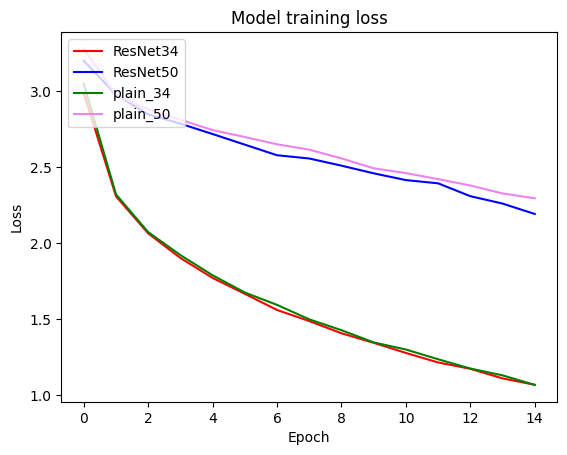

In [75]:
# 성능 시각화
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'violet')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet34', 'ResNet50', 'plain_34','plain_50'], loc='upper left')
plt.show()

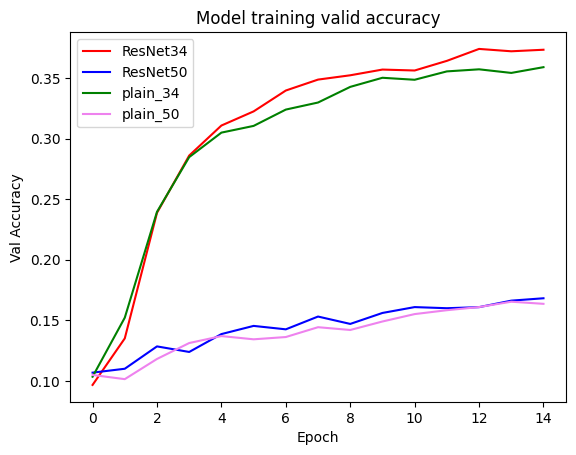

In [77]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'violet')
plt.title('Model training valid accuracy')
plt.ylabel('Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet34', 'ResNet50', 'plain_34','plain_50'], loc='upper left')
plt.show()

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
---
#### Ablation Study
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

- [데이터 불러오기](https://okdone.tistory.com/28)

In [24]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

In [18]:
# image processing 244 * 244
def normalize_and_resize_img_cat_dog(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset_cat_dog(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img_cat_dog, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [26]:
ds_train_2

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
BATCH_SIZE = 128
EPOCH = 15
ds_train_2 = apply_normalize_on_dataset_cat_dog(ds_train, batch_size=BATCH_SIZE)
ds_val_2 = apply_normalize_on_dataset_cat_dog(ds_val, batch_size=BATCH_SIZE)

#### 시각화
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

In [28]:
resnet_34_model_2 = build_resnet(num_classes = 10,input_shape=(224,224,3), is_50=False)
resnet_34_model_2.summary()

build 34 mode!
3
4
5
Model: "resnet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_4[0][0]']               
 ormalization)                  )                                    

In [29]:
resnet_34_model_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

In [30]:
history_plain_34_2 = resnet_34_model_2.fit(
    ds_train_2,
    steps_per_epoch=int(ds_info.splits['train[:70%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val_2,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


2023-02-23 20:40:00.592904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
2023-02-23 20:40:11.529452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 94 of 200
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
2023-02-23 20:40:21.900174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 150 of 200


: 

: 

#### 추가 실험
시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다
- [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)